# Test evaluation task suite for AI data designer

## Setup API key and imports

In [70]:
import sys
import os

# Define the root directory and add it to the path
notebook_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(notebook_dir, '..', '..', '..'))
sys.path.insert(0, root_dir)

# set environment variable 'GRETEL_PROD_API_KEY' from https://console.gretel.ai/users/me/key
gretel_prod_api_key = input("Enter your Gretel API key from https://console.gretel.ai/users/me/key: ")
os.environ['GRETEL_PROD_API_KEY'] = gretel_prod_api_key

In [71]:
# Reload packages if you've made changes to the evaluation.py file.
# Alternatively you can restart the kernel to pick up changes

from importlib import reload
import evaluation
reload(evaluation)

import pandas as pd
from pprint import pprint
from navigator_helpers.llms.llm_suite import GretelLLMSuite
from evaluation import BaseEvaluationTaskSuite, NL2PythonEvaluationTaskSuite, NL2SQLEvaluationTaskSuite, VisualizationTaskSuite
from datasets import load_dataset

## Choose Dataset for Evaluation

In [72]:
# Set the number of samples to load from the dataset for testing
# Set to None to use the full dataset
NUM_SAMPLES = 100

datasets_dict = {
    "synthetic_text_to_sql": {
        "dataset_kwargs": {
            "path": "gretelai/synthetic_text_to_sql",
            "split": "train"
        },
        "code_lang": "sql",
        "eval_kwargs":{
            "instruction_col_name": "sql_prompt",
            "code_col_name": "sql",
            "context_col_name": "sql_context"
        }
    },
    "gsm8k": {
        "dataset_kwargs": {
            "path": "openai/gsm8k",
            "name": "main",
            "split": "train"
        },
        "eval_kwargs": {
            "instruction_col_name": "question",
            "code_col_name": "answer",
        }
    },
    "synthetic_gsm8k": {
        "dataset_kwargs": {
            "path": "gretelai/synthetic-gsm8k-reflection-405b",
            "split": "train"
        },
        "eval_kwargs": {
            "instruction_col_name": "question",
            "code_col_name": "answer",
        }
    },
    "xlcost_text_to_code": {
        "dataset_kwargs": {
            "path": "codeparrot/xlcost-text-to-code",
            "split": "train"
        },
        "code_lang": "python",
        "eval_kwargs": {
            "instruction_col_name": "text",
            "code_col_name": "code",
        }
    },
}

# Prompt user to select a dataset
print("Available datasets:")
for key in datasets_dict.keys():
    print(f" - {key}")

selected_dataset = input("\nEnter the name of the dataset to load: ").strip()

# Load the selected dataset
if selected_dataset in datasets_dict:
    dataset_dict = datasets_dict[selected_dataset]
    eval_kwargs = dataset_dict["eval_kwargs"]
    code_lang = dataset_dict["code_lang"] if "code_lang" in dataset_dict.keys() else None
    dataset = load_dataset(**dataset_dict["dataset_kwargs"])

    # Optionally, select a subset if NUM_SAMPLES is specified
    if NUM_SAMPLES is not None and NUM_SAMPLES < len(dataset):
        dataset = dataset.select(range(NUM_SAMPLES))
    
    dataset_df = dataset.to_pandas()
    
    print(f"Loaded dataset '{selected_dataset}' successfully!")
else:
    print("Error: Dataset not found. Please enter a valid dataset name.")

Available datasets:
 - synthetic_text_to_sql
 - gsm8k
 - synthetic_gsm8k
 - xlcost_text_to_code
Loaded dataset 'synthetic_text_to_sql' successfully!


## Run Evaluation on dataset

In [73]:
llm_suite = GretelLLMSuite()

2024-10-11 06:05:46.193 - INFO - 🦜 Initializing LLM suite
2024-10-11 06:05:46.195 - INFO - 📖 Natural language LLM: gretelai-mistral-nemo-2407
2024-10-11 06:05:46.196 - INFO - 💻 Code LLM: gretelai-mistral-nemo-2407
2024-10-11 06:05:46.196 - INFO - ⚖️ Judge LLM: gretelai-mistral-nemo-2407


In [74]:
# Define a dictionary to store evaluation results
results = {}

# Uncomment the following lines to run individual evaluation tasks
# results.update(BaseEvaluationTaskSuite(llm_suite, dataset_pd).row_uniqueness())
# results.update(BaseEvaluationTaskSuite(llm_suite, dataset_pd).feature_cardinality())
# results.update(BaseEvaluationTaskSuite(llm_suite, dataset_pd).feature_distribution())
# results.update(BaseEvaluationTaskSuite(llm_suite, dataset_pd).num_words_per_record())
# pprint(results)

results = BaseEvaluationTaskSuite(llm_suite, dataset_df, code_lang, eval_kwargs).evaluate_all()
pprint(results)

#results = NL2PythonEvaluationTaskSuite(llm_suite, dataset_pd, code_lang="python").evaluate_all()
#pprint(results)

{'feature_cardinality': {'domain': 0.6,
                         'domain_description': 0.6,
                         'id': 1.0,
                         'sql': 1.0,
                         'sql_complexity': 0.06,
                         'sql_complexity_description': 0.06,
                         'sql_context': 1.0,
                         'sql_explanation': 1.0,
                         'sql_prompt': 1.0,
                         'sql_task_type': 0.04,
                         'sql_task_type_description': 0.04},
 'feature_distribution': {'distribution': {'domain': None,
                                           'domain_description': {'avg_length': 112.12,
                                                                  'avg_word_count': 13.3,
                                                                  'std_length': 13.61318434014569,
                                                                  'word_count_histogram': [0,
                                                

## Visualization of Evaluation Results

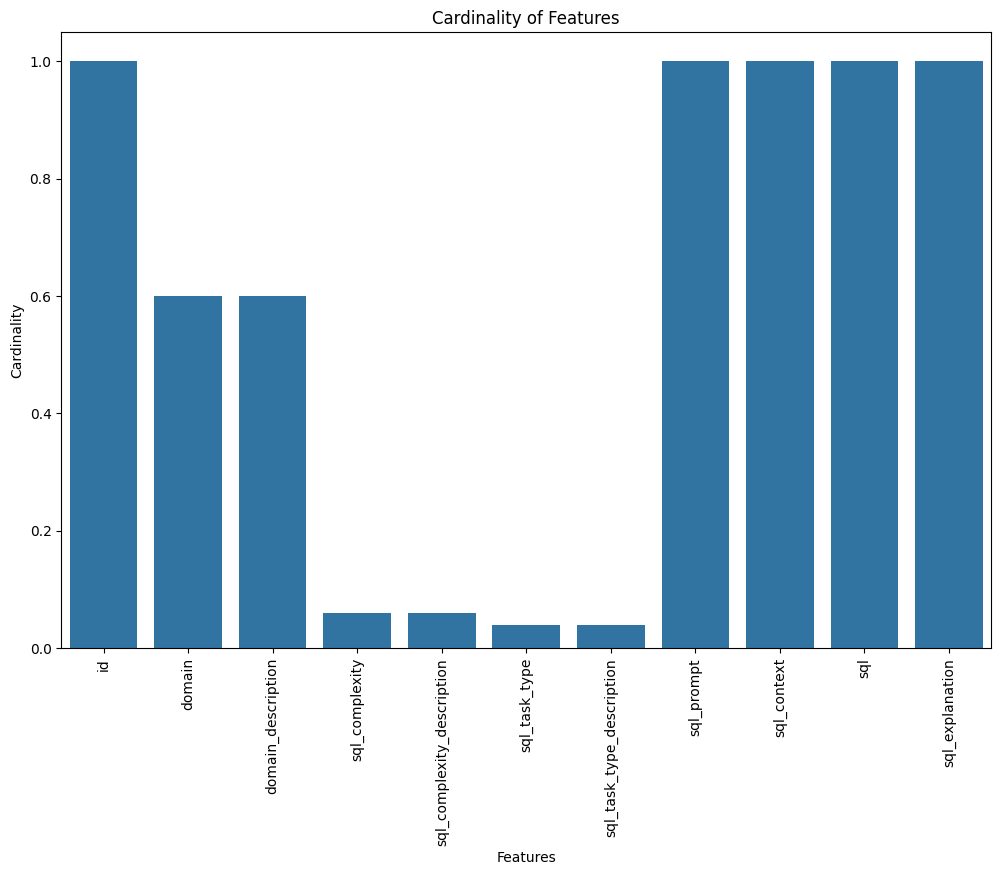

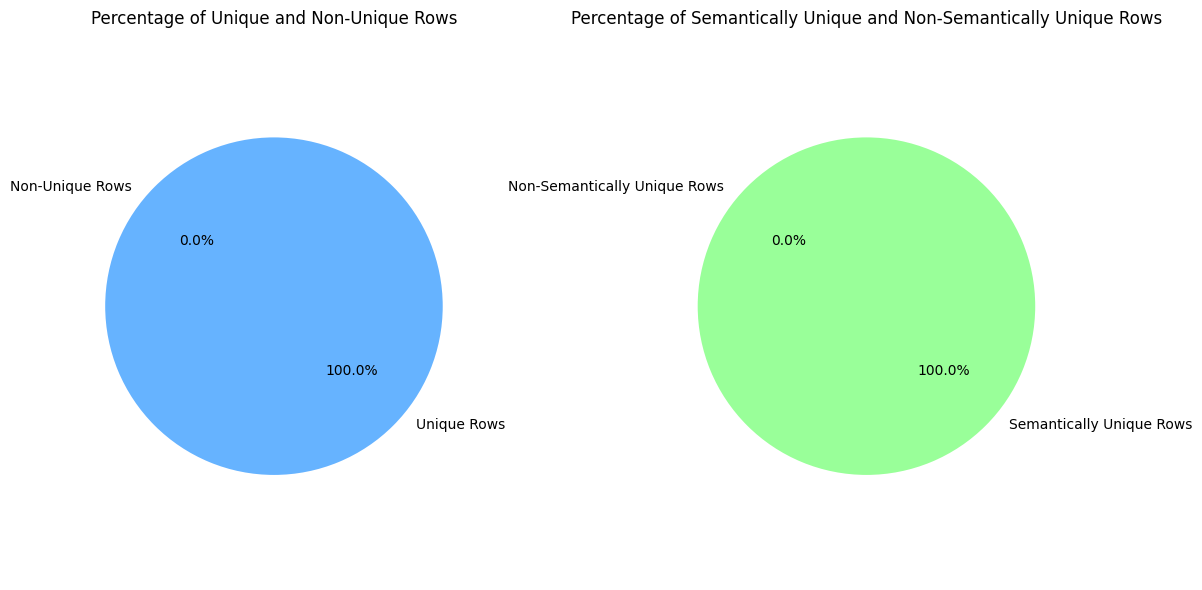

/mnt/foundation-shared/dhruv_gretel_ai/navigator-helpers/navigator_helpers/tasks/evaluation/evaluation.py:608: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


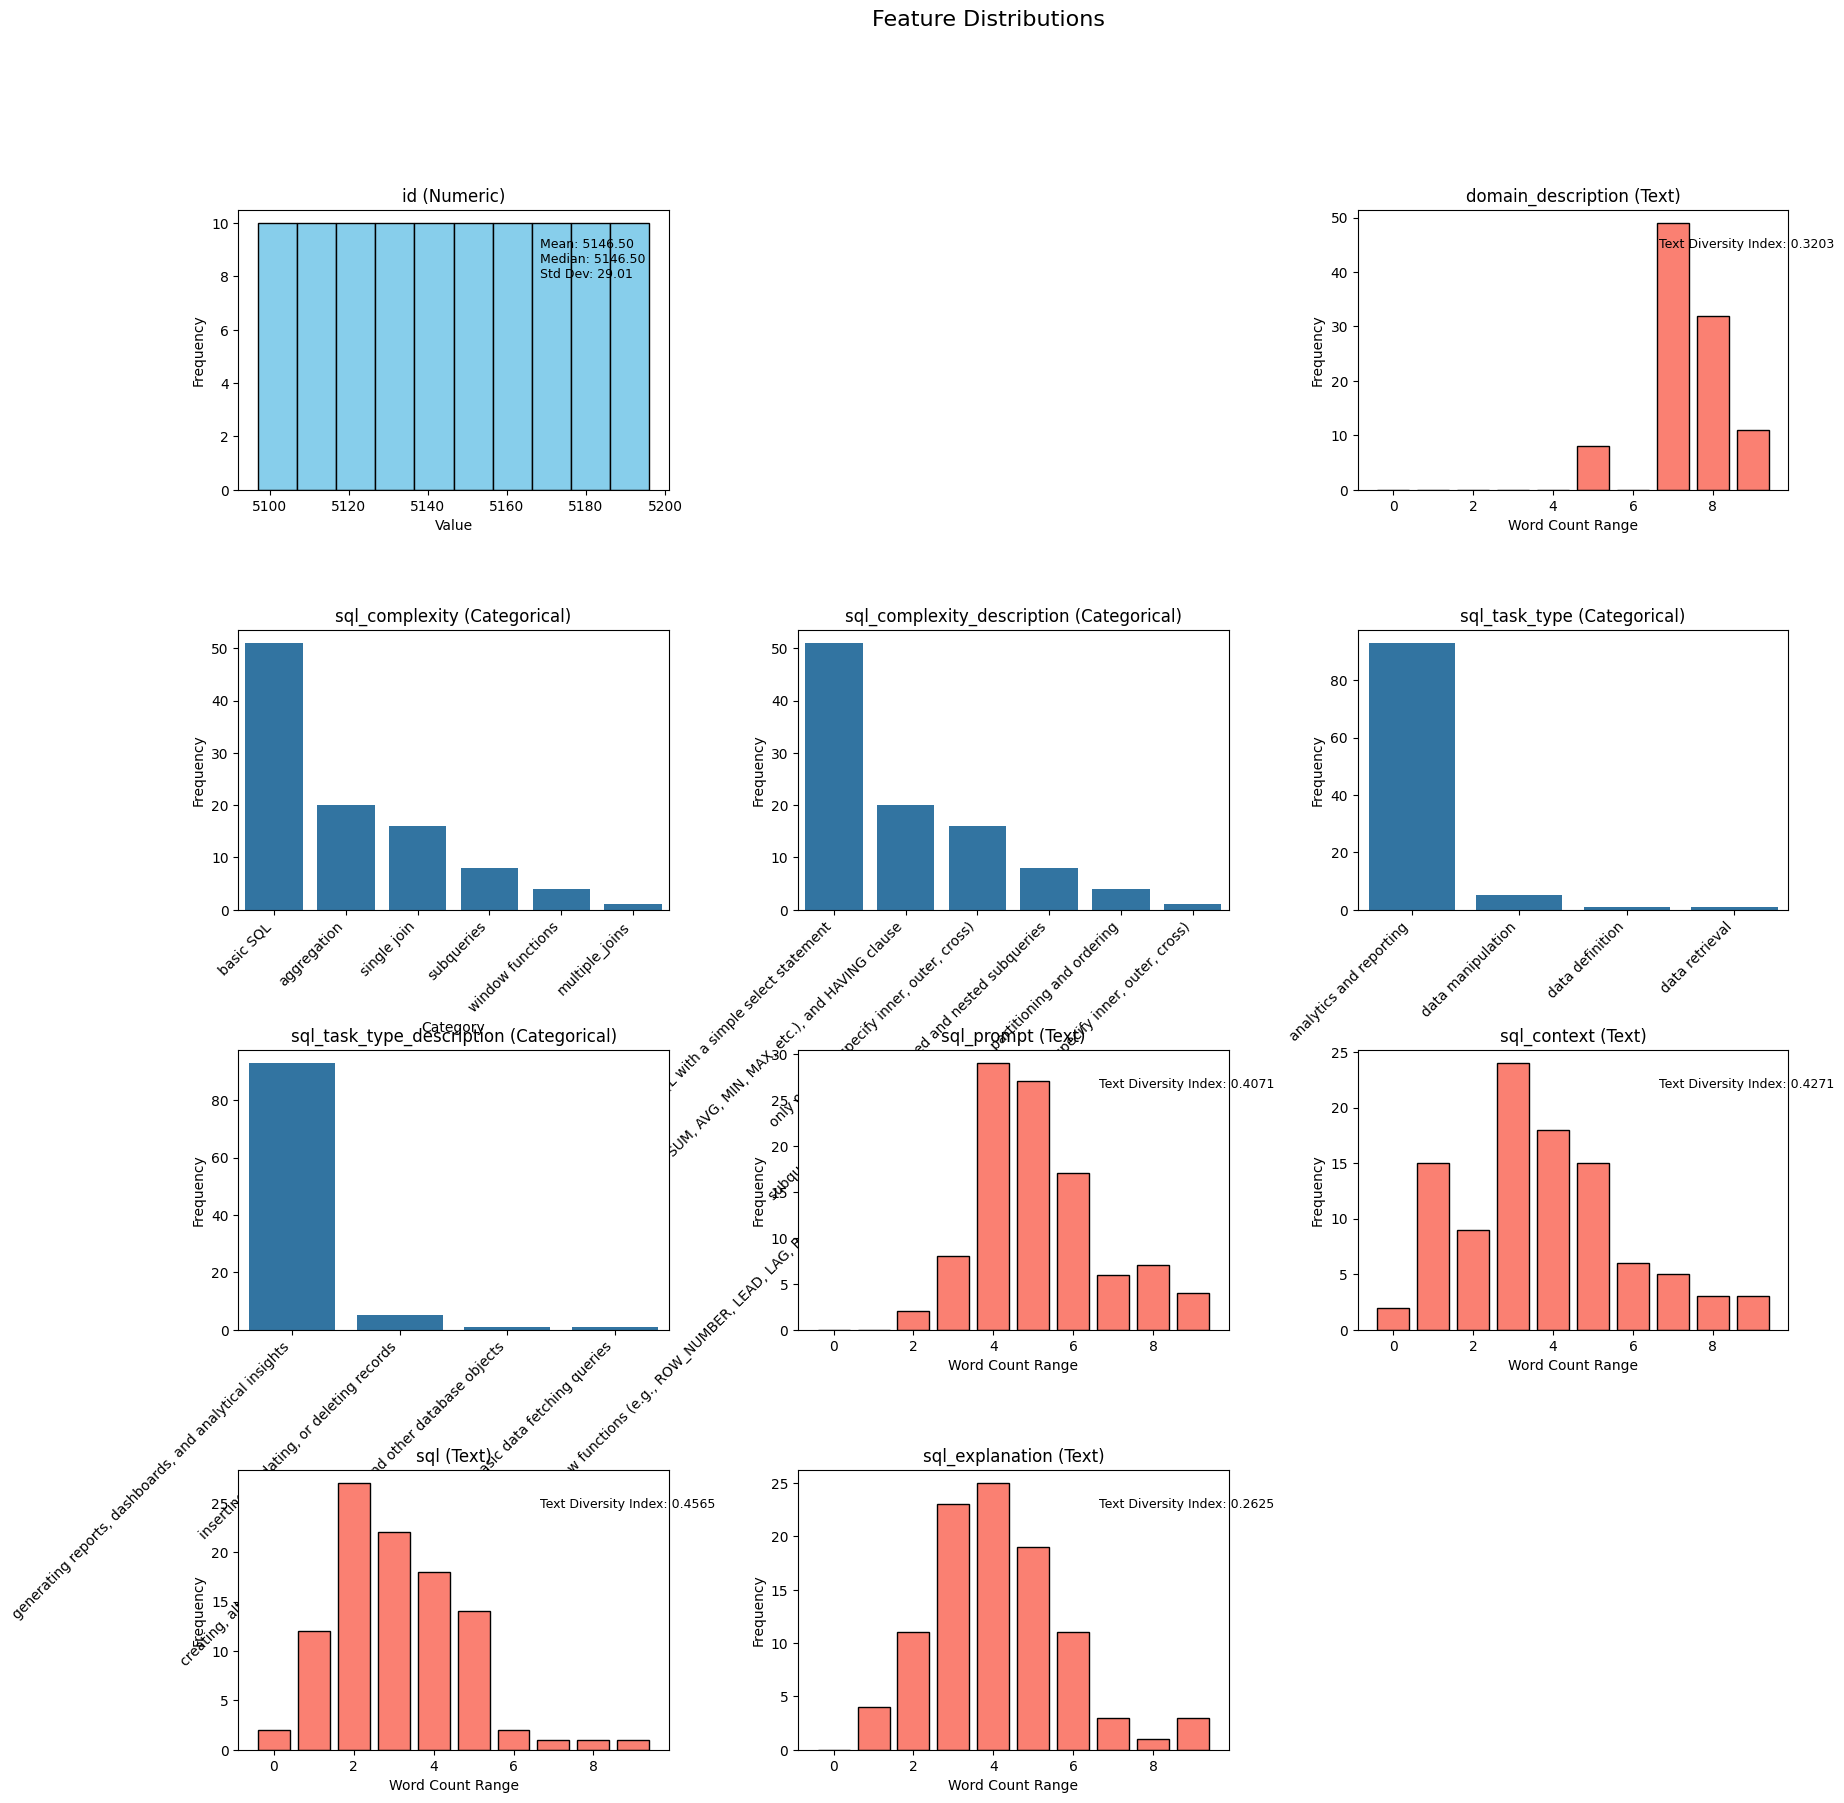

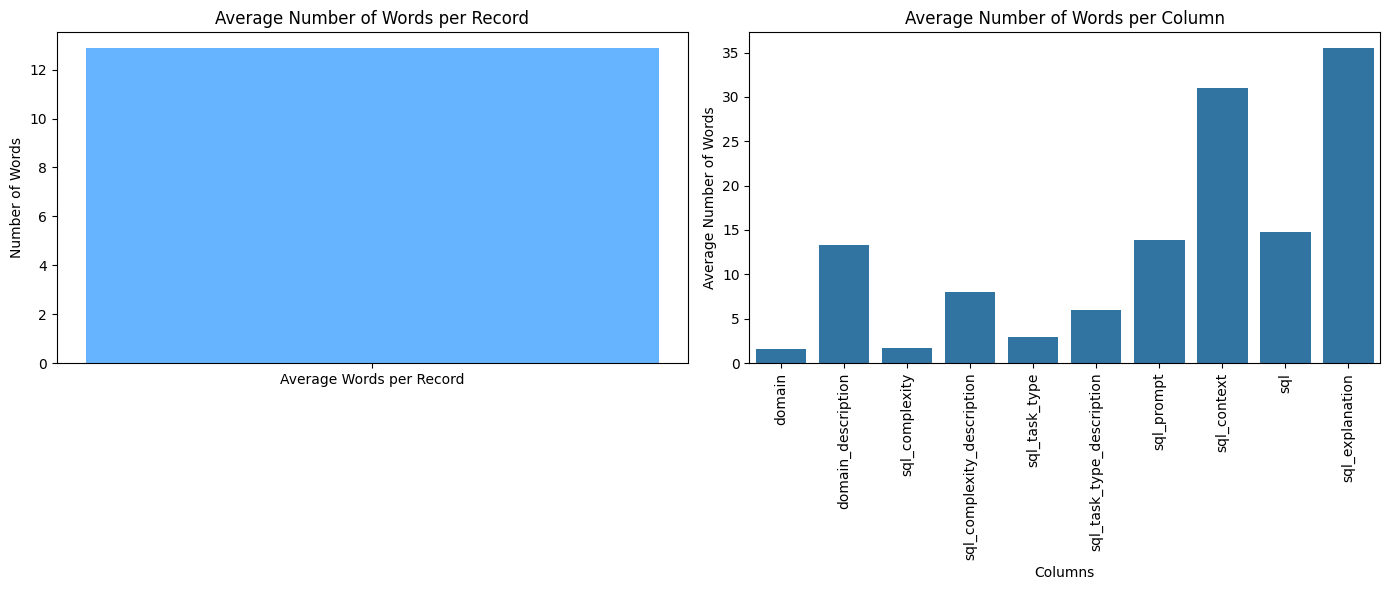

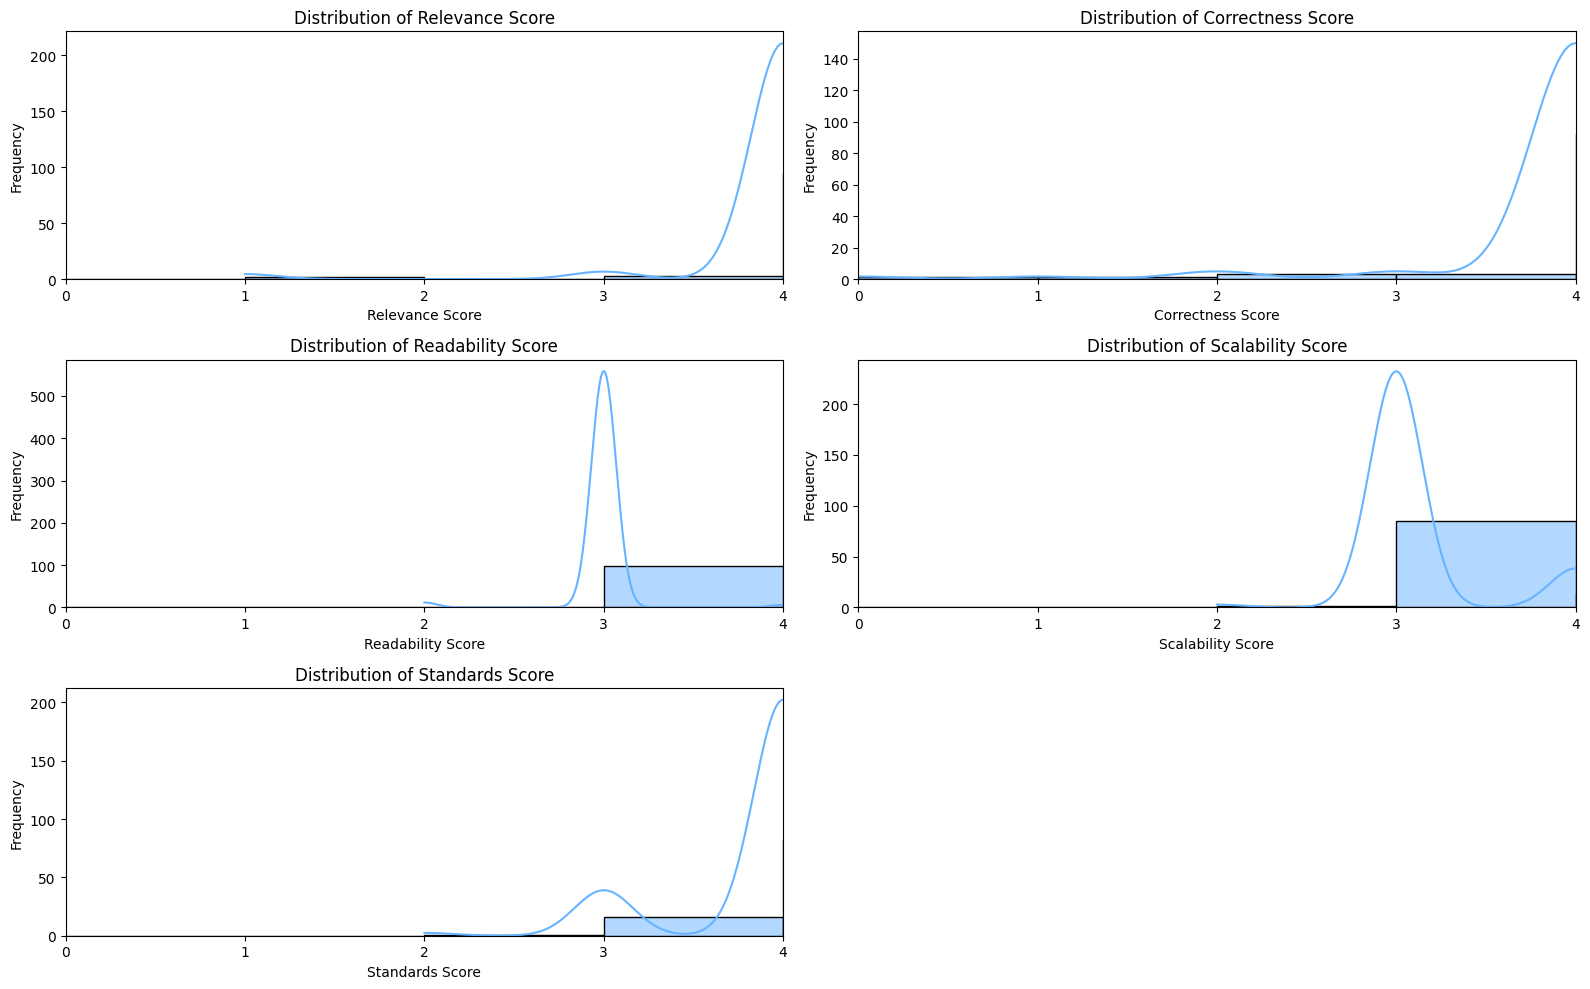

In [75]:
vis_suite = VisualizationTaskSuite(dataset_df, results)

# Uncomment to visualize individual evaluation test plots
#vis_suite.plot_feature_cardinality()
#vis_suite.plot_row_uniqueness()
#vis_suite.plot_feature_distribution()
#vis_suite.plot_num_words_per_record()

vis_suite.visualize_all()

### Testing LLM-as-a-Judge Evaluation

### Testing LLM-as-a-Judge Evaluation

In [69]:
# if code_lang == "sql":
#     task = NL2SQLEvaluationTaskSuite(
#         llm_suite=llm_suite, dataset=dataset_df, code_lang="sql"
#     )
# elif code_lang == "python":
#     task = NL2PythonEvaluationTaskSuite(
#         llm_suite=llm_suite, dataset=dataset_df, code_lang="python"
#     )
# else:
#     task = BaseEvaluationTaskSuite(llm_suite, dataset_df)
# results = task.llm_as_a_judge_evaluation(**eval_kwargs)
# table = task.output_dataset